<a href="https://colab.research.google.com/github/fudw/tensorflow-developer-professional-certificate/blob/main/U_Net_semantic_segmentation_Oxford_IIIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

In [ ]:
dataset, info = tfds.load("oxford_iiit_pet:3.*.*", with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteRSIBI7/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteRSIBI7/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

In [ ]:
import json
with open("/root/tensorflow_datasets/oxford_iiit_pet/3.2.0/features.json", "r") as f:
    features = json.load(f)

print(features)

{'type': 'tensorflow_datasets.core.features.features_dict.FeaturesDict', 'content': {'image': {'type': 'tensorflow_datasets.core.features.image_feature.Image', 'content': {'shape': [None, None, 3], 'dtype': 'uint8', 'encoding_format': None}}, 'label': {'type': 'tensorflow_datasets.core.features.class_label_feature.ClassLabel', 'content': {'num_classes': 37}}, 'species': {'type': 'tensorflow_datasets.core.features.class_label_feature.ClassLabel', 'content': {'num_classes': 2}}, 'file_name': {'type': 'tensorflow_datasets.core.features.text_feature.Text', 'content': {}}, 'segmentation_mask': {'type': 'tensorflow_datasets.core.features.image_feature.Image', 'content': {'shape': [None, None, 1], 'dtype': 'uint8', 'encoding_format': None}}}}


In [ ]:
with open("/root/tensorflow_datasets/oxford_iiit_pet/3.2.0/label.labels.txt", "r") as t:
    for line in t:
        print(line)

In [ ]:
with open("/root/tensorflow_datasets/oxford_iiit_pet/3.2.0/species.labels.txt", "r") as t:
    for line in t:
        print(line)

In [ ]:
print(dataset)

{'test': <PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>, 'train': <PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}


In [ ]:
print(dataset["train"])

<PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


In [ ]:
example, = dataset["train"].take(1)
example_image, example_label, example_mask = example["image"], example["label"], example["segmentation_mask"]

In [ ]:
def visualise_image_and_mask(image, mask):
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(keras.utils.array_to_img(image))
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(keras.utils.array_to_img(mask))
    plt.axis("off")

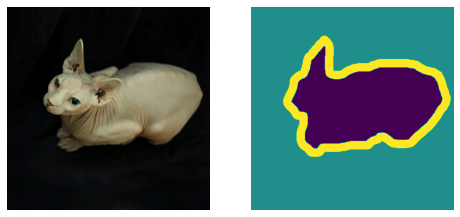

In [ ]:
visualise_image_and_mask(example_image, example_mask)

In [ ]:
example_mask.shape

TensorShape([500, 500, 1])

In [ ]:
def resize_and_normalise(image, mask, size):
    #print(image.shape)
    #print(mask.shape)
    #mask = tf.expand_dims(mask, axis=2)
    image = layers.Resizing(size, size)(image)
    mask = layers.Resizing(size, size)(mask)
    #mask = tf.squeeze(mask, axis=-1)
    image = tf.cast(image, tf.float32) / 255.0
    mask = tf.cast(mask, tf.uint8) - 1
    
    return image, mask

def augment(image, mask, image_size):
    #print(image.shape)
    #print(mask.shape)
    combined = tf.concat([image, mask], axis=-1)
    augmented = layers.RandomCrop(image_size, image_size, 4)(combined)
    augmented = layers.RandomFlip("horizontal")(augmented)
    #augmented = layers.RandomRotation(factor=0.2, fill_mode="nearest")(augmented)
    #augmented = layers.RandomZoom(height_factor=0.2, width_factor=0.2, fill_mode="nearest")(augmented)
    augmented_image, augmented_mask = augmented[:, :, :-1], augmented[:, :, -1:]
    #print(augmented_image.shape)
    #print(augmented_mask.shape)

    return augmented_image, augmented_mask

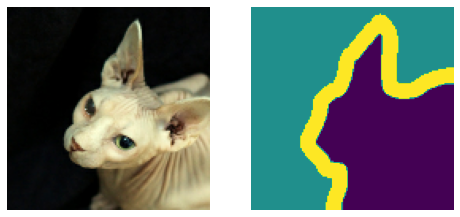

In [ ]:
image_size = 128
crop_size = 256
processed_image, processed_mask = augment(example_image, example_mask, crop_size)
processed_image, processed_mask = resize_and_normalise(processed_image, processed_mask, image_size)
visualise_image_and_mask(processed_image, processed_mask)

In [ ]:
def preprocess_train_data(example):
    image, mask = example["image"], example["segmentation_mask"]
    processed_image, processed_mask = augment(image, mask, crop_size)
    processed_image, processed_mask = resize_and_normalise(processed_image, processed_mask, image_size)
    
    return processed_image, processed_mask

def preprocess_test_data(example):
    image, mask = example["image"], example["segmentation_mask"]
    processed_image, processed_mask = resize_and_normalise(image, mask, image_size)

    return processed_image, processed_mask

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = dataset["train"].map(preprocess_train_data, num_parallel_calls=AUTOTUNE)
test_dataset = dataset["test"].map(preprocess_test_data, num_parallel_calls=AUTOTUNE)

In [ ]:
train_dataset

<ParallelMapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))>

In [ ]:
test_dataset

<ParallelMapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))>

In [ ]:
np.unique(train_example[1].numpy())

array([0, 1, 2], dtype=uint8)

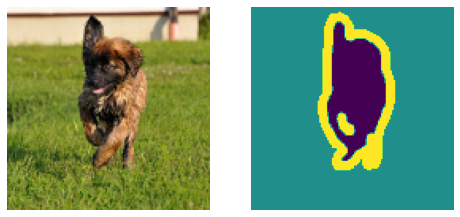

In [ ]:
train_example, = test_dataset.take(1)
#print(train_example)
visualise_image_and_mask(train_example[0], train_example[1])

In [ ]:
batch_size = 64
buffer_size = 1000
train_batches = train_dataset.shuffle(buffer_size).batch(batch_size).repeat().cache().prefetch(AUTOTUNE)
test_batches = test_dataset.take(3000).batch(batch_size)
valid_batches = test_dataset.skip(3000).take(669).batch(batch_size)

In [ ]:
def conv_block(x, num_filters):
    x = layers.Conv2D(num_filters, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.Conv2D(num_filters, kernel_size=3, padding="same", activation="relu")(x)

    return x

def downsample_block(x, num_filters):
    feature_map = conv_block(x, num_filters)
    x = layers.MaxPool2D(pool_size=2)(feature_map)
    x = layers.Dropout(0.3)(x)

    return feature_map, x

def upsample_block(x, feature_map, num_filters):
    x = layers.Conv2DTranspose(num_filters, kernel_size=3, strides=2, padding="same")(x)
    x = layers.Concatenate()([x, feature_map])
    x = layers.Dropout(0.3)(x)
    x = conv_block(x, num_filters)

    return x

In [ ]:
def build_unet():
    inputs = layers.Input(shape=(image_size, image_size, 3))

    f1, x1 = downsample_block(inputs, 64)
    f2, x2 = downsample_block(x1, 128)
    f3, x3 = downsample_block(x2, 256)
    f4, x4 = downsample_block(x3, 512)

    bottleneck = conv_block(x4, 1024)

    u4 = upsample_block(bottleneck, f4, 512)
    u3 = upsample_block(u4, f3, 256)
    u2 = upsample_block(u3, f2, 128)
    u1 = upsample_block(u2, f1, 64)

    outputs = layers.Conv2D(3, kernel_size=1, padding="same", activation="softmax")(u1)

    unet = keras.Model(inputs=inputs, outputs=outputs)

    return unet

In [ ]:
unet = build_unet()

In [ ]:
keras.utils.plot_model(unet, show_shapes=True, )

In [ ]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
learning_rate = 0.001
num_epochs = 50
unet.compile(
    optimizer=tf.optimizers.Adam(learning_rate),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)
checkpoint_path = "tmp/checkpoint"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

In [ ]:
train_steps = info.splits["train"].num_examples // batch_size
valid_steps = 669 // batch_size

history = unet.fit(
    train_batches,
    steps_per_epoch=train_steps,
    epochs=num_epochs,
    validation_data=valid_batches,
    validation_steps=valid_steps,
    callbacks=[checkpoint_callback],
)

Epoch 1/50
57/57 [==============================] - 134s 2s/step - loss: 0.9378 - accuracy: 0.5220 - val_loss: 0.8072 - val_accuracy: 0.6078
Epoch 2/50
 1/57 [..............................] - ETA: 9:44 - loss: 0.8292 - accuracy: 0.6029WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 2850 batches). You may need to use the repeat() function when building your dataset.


57/57 [==============================] - 13s 54ms/step - loss: 0.8292 - accuracy: 0.6029 - val_loss: 0.8045 - val_accuracy: 0.6118


In [ ]:
unet.evaluate(train_batches)

58/58 [==============================] - 38s 534ms/step - loss: 0.5728 - accuracy: 0.7740


[0.5727980732917786, 0.773963987827301]

In [ ]:
prediction = unet(tf.expand_dims(processed_image, axis=0))

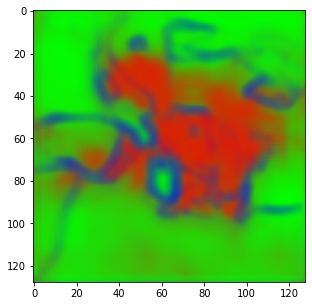

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(keras.utils.array_to_img(prediction[0]))

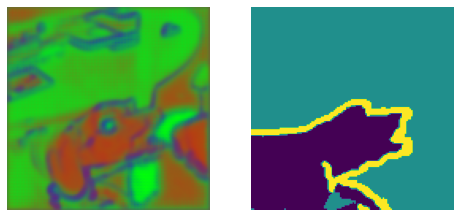

In [ ]:
visualise_image_and_mask(prediction[0], processed_mask)

In [ ]:
keras.losses.sparse_categorical_crossentropy(processed_mask, prediction[0], from_logits=True)

<tf.Tensor: shape=(128, 128), dtype=float32, numpy=
array([[0.8590635 , 0.7874296 , 0.7393521 , ..., 0.6390654 , 0.6663124 ,
        0.76271796],
       [0.8343996 , 0.78179973, 0.7345016 , ..., 0.6156778 , 0.6393429 ,
        0.69702566],
       [0.8028048 , 0.75093573, 0.72096074, ..., 0.6054818 , 0.62127674,
        0.67588115],
       ...,
       [0.82333654, 0.8009596 , 0.81117976, ..., 0.7234193 , 0.7205755 ,
        0.73640937],
       [0.8492693 , 0.83704954, 0.8156898 , ..., 0.716852  , 0.7240423 ,
        0.76906365],
       [0.9225073 , 0.88292146, 0.8550615 , ..., 0.77106446, 0.77774847,
        0.83477646]], dtype=float32)>

In [ ]:
print()